In [1]:
import numpy as np
import math
import copy
import time
import scipy.stats

from utils import ExtObjectDataAssociator

class PF:
    def __init__(self, N):
        self.N = N
        self.ext_object_associator = ExtObjectDataAssociator(dim=2,deltaL=1,deltaS=1,deltaE=1)
        #Radar measurements estimated errors
        self.sigma_r = 0.2
        self.sigma_theta = 0.01
        #IMU measurements estimated errors
        self.sigma_rot1 = 0.01
        self.sigma_trans = 0.04
        self.sigma_rot2 = 0.01
        
    @staticmethod
    def getXYLimits(extTrack):
        xs = extTrack.getStateVector()[3]
        xe = extTrack.getStateVector()[3]
        a0, a1, a2 = extTrack.getStateVector()[0], extTrack.getStateVector()[1], extTrack.getStateVector()[2]
        y_start = a0 + a1 * xs + a2 * xs**2
        y_end = a0 + a1 * xe + a2 * xe**2
        
        return xs,xe,ys,ye
    
    @staticmethod
    def world2Map(pos, worldRef, mapRef):
        pos[0] -= worldRef[0]
        pos[1] -= worldRef[1]
        dtheta = mapRef[2] - worldRef[2]
        transform_matrix = np.array([[np.cos(dtheta), -np.sin(dtheta)],
                                     [np.sin(dtheta), np.cos(dtheta)]])
        
        transformed_pose = np.dot(transform_matrix, pos)
        transformed_pose[0] += mapRef[0]
        transformed_pose[1] += mapRef[1]
        
        return transformed_pose
    
    @staticmethod
    def map2World(pos, worldRef, mapRef):
        pos[0] -= mapRef[0]
        pos[1] -= mapRef[1]
        dtheta = worldRef[2] - mapRef[2]
        transform_matrix = np.array([[np.cos(dtheta), -np.sin(dtheta)],
                                     [np.sin(dtheta), np.cos(dtheta)]])
        
        transformed_pose = np.dot(transform_matrix, pos)
        transformed_pose[0] += worldRef[0]
        transformed_pose[1] += worldRef[1]
        
        return transformed_pose
    
    @staticmethod
    def transformMap(roadMap, inputPos, particle):
        height, width = roadMap.shape[:2]
        padded_map = cv2.copyMakeBorder(roadMap, int(height/2), int(height/2), int(width/2), int(width/2), cv2.BORDER_CONSTANT, 0)
        height, width = padded_map.shape[:2]
        dx = inputPos["x"]-particle["x"]
        dy = inputPos["y"]-particle["y"]
        dtheta = inputPos["theta"]-particle["theta"]
        center = (width/2-dx, height/2-dy)
        rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=dtheta, scale=1)
        transform_matrix = rotate_matrix
        transform_matrix[0,2] += dx
        transform_matrix[1,2] += dy

        transformed_map = cv2.warpAffine(src=padded_map, M=transform_matrix, dsize=(width, height))
        
        center = np.array([center[0],center[1],1])
        transformed_center = np.dot(transform_matrix,np.array(center))
        
        return transformed_map, transformed_center
   
    @staticmethod
    def computeDist(extTrack, sx, sy):
        state = extTrack.getStateVector()
        P = ext_track.getCovarianceMatrix()
        Ha = np.array([1, sx, sx**2])
        P_match = np.dot(np.dot(Ha, P[0:3,0:3]), Ha.T)
        y_match = state[0] + state[1] * sx + state[2] * sx**2
        
        return self.ext_object_associator.calcLikelihood(sx, sy, y_match, P_match, state)

    def apply_motion_model(odometry, state):
        delta_rot1 = odometry['r1']
        delta_trans = odometry['t']
        delta_rot2 = odometry['r2']

        state['x'] += delta_trans * np.cos(state['theta']+delta_rot1)
        state['y'] += delta_trans * np.sin(state['theta']+delta_rot1)
        state['theta'] += delta_rot1 + delta_rot2

        return state

    def initialize_particles(num_particles):
        particles = []

        for i in range(num_particles):
            particle = dict()

            #random position inside a unity circle
            t = 2*np.pi*np.random.uniform(0, 1)
            u = np.random.uniform(0, 1)+np.random.uniform(0, 1)
            r = 2-u if u>1 else u

            diameter = 2 #Estimated error in the beginning
            xc = 1
            yc = 1
            #initialize pose: at the beginning, robot is certain it is at [0,0,0]
            particle['x'] = diameter*r*np.cos(t) + xc
            particle['y'] = diameter*r*np.sin(t) + yc
            particle['theta'] = 0

            #initial weight
            particle['weight'] = 1.0 / num_particles

            #particle history aka all visited poses
            particle['history'] = []

            #add particle to set
            particles.append(particle)

        return particles

    def sample_motion_model(odometry, particles):
        # Updates the particle positions, based on old positions, the odometry
        # measurements and the motion noise 

        delta_rot1 = odometry['r1']
        delta_trans = odometry['t']
        delta_rot2 = odometry['r2']

        # the motion noise parameters: [alpha1, alpha2, alpha3, alpha4]

        for particle in particles:
            noise_delta_rot1 = delta_rot1 + np.random.normal(0, sigma_rot1)
            noise_delta_trans = delta_trans + np.random.normal(0, sigma_trans)
            noise_delta_rot2 = delta_rot2 + np.random.normal(0, sigma_rot2)
            particle['x'] += noise_delta_trans * np.cos(particle['theta']+noise_delta_rot1)
            particle['y'] += noise_delta_trans * np.sin(particle['theta']+noise_delta_rot1)
            particle['theta'] += noise_delta_rot1 + noise_delta_rot2
            #particle['history'].append(np.array([particle['x'], particle['y']]))
        '''***        ***'''
        
        return particles

    def eval_sensor_model(particles, posInput, extTracks, roadMap):
        #rate each particle
        for ext_track in extTracks:
            for particle in particles:
                P_total = 0 # for accumulating probabilities
                #transform map according to posInput and particle info
                transformed_map, transformed_center = transformMap(roadMap, posInput, particle)
                world_xs,world_xe,world_ys,world_ye = getXYLimits(ext_track, posInput)
                map_limits = world2Map(np.array([[world_xs,world_ys],[world_xe,world_ye]]), inputPos, transformed_center)
                map_xs,map_xe,map_ys,map_ye = map_limits[0,0], map_limits[0,1], map_limits[1,0], map_limits[1,1]
                (row,col) = np.where(transformed_map[map_xs:map_xe,map_ys:map_ye])
                for imap in range(0,row.shape[0]):
                    seg_pos = map2World(np.array([row[imap], col[imap]]), inputPos, transformed_center)
                    sx = seg_pos[0]
                    sy = seg_pos[1]
                    #calculate likelihood of matching between polynom and map-segment
                    Pi = computeDist(ext_track, sx, sy)
                    #combine (independent) measurements
                    P_total += Pi
                particle['weight'] = P_total

        #normalize weights
        normalizer = sum([p['weight'] for p in particles])

        for particle in particles:
            particle['weight'] = particle['weight'] / normalizer
            
        return particles


    def resample_particles(particles):
        # Returns a new set of particles obtained by performing
        # stochastic universal sampling, according to the particle 
        # weights.

        new_particles = []

        '''your code here'''
        # Uniform distribution value
        uni_val = 1.0/len(particles)
        # Uniform distribution
        u = np.random.uniform(0,uni_val)
        # Initialize total weight
        w = 0

        #loop over all particle weights
        for particle in particles:
            w += particle['weight']
            while u <= w:
                new_particle = copy.deepcopy(particle)
                new_particle['weight'] = uni_val
                new_particles.append(new_particle)
                u += uni_val
        '''***        ***'''
        return new_particles

In [2]:
#read data from imu and convert to rot1, trans, rot2
#convert drivable area to (x,y) border points
#rotate-translate ext_object 

In [3]:
#1. read data from imu and convert to rot1,trans,rot2
from pyquaternion import Quaternion
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

directory = r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini"
nusc_can = NuScenesCanBus(dataroot=directory)

scene_name = 'scene-0001'

def getOdometry(scene_name, i):
    if i == 0:
        return 
    q = nusc_can.get_messages(scene_name, 'ms_imu')
    rot1 = q[i-1]['q']
    rot2 = q[i]['q']
    R1 = Quaternion(rot1).rotation_matrix[0:2,0:2]
    r1 = np.sign(R1[1,0]) * np.arccos(R1[0,0])
    R2 = Quaternion(rot2).rotation_matrix[0:2,0:2]
    r2 = np.sign(R2[1,0]) * np.arccos(R2[0,0])

    veh_speed = nusc_can.get_messages(scene_name, 'zoe_veh_info')
    veh_speed = np.array([(m['utime'], m['odom_speed']) for m in veh_speed])[i-1:i+1, :]
    dT = (veh_speed[1:, 0] - veh_speed[0:-1, 0]) / 1e6
    t = veh_speed[1:, 1] * dT
    odometry = {'r1': r1, 't': t[0], 'r2': r2}
    
    return odometry
    
odom = getOdometry(scene_name=scene_name, i=1)
print(odom)

{'r1': -0.13763524556345458, 't': 0.12177, 'r2': -0.13344095930981578}


(500, 500)
got mask
blurred
before imshow
7623


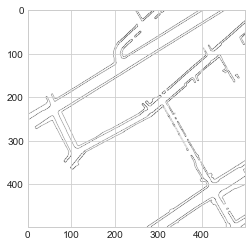

In [5]:
%matplotlib inline
# 2. convert drivable area to (x,y) border points
import cv2
from nuscenes.map_expansion.map_api import NuScenesMap
from matplotlib import pyplot as plt
import numpy as np

def getMapMask(nusc_map, pos):
    patch_angle = 0
    patch_size = 500
    patch_box = (pos[0], pos[1], patch_size, patch_size)
    layer_names = ['walkway']
    canvas_size = (patch_size, patch_size)
    map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size)
    
    return map_mask[0]

directory = r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini"
map_name = "boston-seaport"
nusc_map = NuScenesMap(dataroot=directory, map_name=map_name)
            
pos = [600, 1647]
mask = getMapMask(nusc_map, pos)
#plt.imshow(mask)
print(mask.shape)
print("got mask")
mask_blur = cv2.GaussianBlur(mask, (3,3), 0)
print("blurred")
edges = cv2.Canny(image=mask_blur, threshold1=0.5, threshold2=0.7) # Canny Edge Detection
# Display Canny Edge Detection Image
print("before imshow")
plt.imshow(edges)
print(np.count_nonzero(edges))
#plt.show()

[[217.87993327 217.87993327]
 [191.03852768 191.03852768]]
815
Sanity check: [201. 215.]


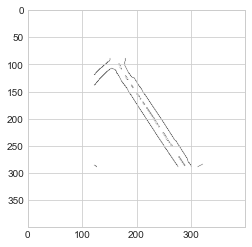

In [270]:
#3. rotate-translate map
pf = PF(100)
particle = {"x": 1010, "y":1020, "theta": 90}
input_pos = {"x": 1000, "y":1000, "theta": 0}

world_xs = 1000.
world_ys = 1000.
world_xe = 1020.
world_ye = 1020.

inpos = np.array([input_pos["x"], input_pos["y"], input_pos["theta"]])
pcl = np.array([particle["x"], particle["y"], particle["theta"]])

transformed_map, transformed_center = pf.transformMap(edges, input_pos, particle)
transformed_center = np.array([transformed_center[0], transformed_center[1], input_pos["theta"]-particle["theta"]])
map_limits = pf.world2Map(np.array([[world_xs,world_ys],[world_xe,world_ye]]), inpos, transformed_center)
print(map_limits)
plt.imshow(transformed_map)
print(np.count_nonzero(transformed_map))

inp = np.array([201,215])
tr = pf.world2Map(inp, inpos, transformed_center)
tr_back = pf.map2World(tr, inpos, transformed_center)
print("Sanity check:", tr_back)

In [240]:
ts = 1533151603630245
#1. read data from imu and convert to rot1,trans,rot2
from pyquaternion import Quaternion
from nuscenes.can_bus.can_bus_api import NuScenesCanBus

directory = r"C:\Users\gadli\old_pc\Tau\Thesis\nuScenes\v1.0-mini"
nusc_can = NuScenesCanBus(dataroot=directory)

scene_name = 'scene-0103'

q = nusc_can.get_messages(scene_name, 'ms_imu')
print(q[0]['utime'], ts)

1533151603550453 1533151603630245


In [145]:
A = np.array([[5,4],[3,3]])
B = np.array([3, 4, 5, 6])

(row,col) = np.where(A)
for i in range(0,row.shape[0]):
    x = row[i] + 1000
    y = col[i] + 1000
    print(x,y)

1000 1000
1000 1001
1001 1000
1001 1001
